### Goal: Train a model to segment nucleii from C. elegans Fluorescence Microscopy data

In [2]:
import os, sys
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time

from os import listdir
from os.path import isfile, join
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
torchvision.__version__

'0.15.1'

### Copy Preprocessed data from GDrive or load data in kaggle:

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

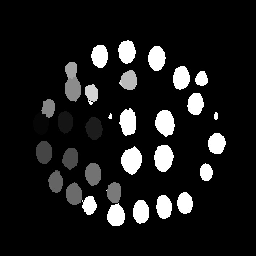

In [9]:
Image.open('/kaggle/input/nuclear-seg/new_dataset/final_seg_maps/L100_17.png')


### Resize Images to 256x256 if havent already


In [18]:
# def resize(path):
#   dirs = os.listdir( path )
#   for item in tqdm(dirs):
#     if os.path.isfile(path+item):
#       im = Image.open(path+item)
#       f, e = os.path.splitext(path+item)
#       imResize = im.resize((256,256), Image.NEAREST)
#       imResize.save(f+e, 'PNG', quality=100)

features_path, label_path = "/kaggle/input/nuclear-seg/new_dataset/final_features", "/kaggle/input/nuclear-seg/new_dataset/final_seg_maps"
# resize(label_path)
# resize(features_path)

### Create a csv containing image id's

In [19]:
ids=[]
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
  ids.append(label_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')


1106


In [20]:
df.head()

,file_ids
0,42_20.png
1,21_10.png
2,101_31.png
3,100_24.png
4,16_13.png


### Define Custom Dataset Class

In [22]:
# My implementation
class MySegmentationDataset(Dataset):
    def __init__(self, csv, augmentation =None, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]

        # All transforms to be applied
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):

        # Load image and masks
        # Convert image to RGB not masks
        # convert PIL Image and mask to numpy array
        image= np.array(Image.open("/kaggle/input/nuclear-seg/new_dataset/final_features/F"+self.ids[idx]).convert("RGB"))
        # mask=np.array(Image.open("/content/content/segmentation_maps/L"+self.ids[idx]))
        mask=np.array(Image.open("/kaggle/input/nuclear-seg/new_dataset/final_seg_maps/L"+self.ids[idx]))
        
#         image= np.array(Image.open("/content/content/features/F"+self.ids[idx]).convert("RGB"))
        # mask=np.array(Image.open("/content/content/segmentation_maps/L"+self.ids[idx]))
#         mask =np.array(Image.open("/content/content/segmentation_maps/L"+self.ids[idx]))
#         if self.augmentation is not None:
#           augmented  = self.augmentation(image = image, mask = mask)
#           image = augmented["image"]
#           mask = augmented["mask"]

        # mask[mask != 0] = 1

        # # This converts to to tensor and to float
        # mask = self.transform_label(mask)
        # mask = mask.float()

        # We get the unique colors, as these would be the object ids.
        obj_ids = np.unique(mask)

        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of boolean masks.
        # Note that this snippet would work as well if the masks were float values instead of ints.
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmax > xmin and ymax > ymin:
              boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1,4)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
#         image_id = idx
        area = (boxes.reshape(-1,4)[:, 3] - boxes.reshape(-1,4)[:, 1]) * (boxes.reshape(-1,4)[:, 2] - boxes.reshape(-1,4)[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.augmentation is not None:
            image, target = self.augmentation(image, target)

        # return img, target


        return self.transform_image(image), target
        # return image, target

    def __len__(self):
        return len(self.ids)

In [24]:
# My implementation
class MySegmentationDataset(Dataset):
    def __init__(self, csv, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]

        # All transforms to be applied
        self.transform_image = transform_image
        self.transform_label = transform_label
    def __getitem__(self, idx):

        # Load image and masks
        # Convert image to RGB not masks
        # convert PIL Image and mask to numpy array
        image= np.array(Image.open("/kaggle/input/nuclear-seg/new_dataset/final_features/F"+self.ids[idx]).convert("RGB"))
        # mask=np.array(Image.open("/content/content/segmentation_maps/L"+self.ids[idx]))
        mask=np.array(Image.open("/kaggle/input/nuclear-seg/new_dataset/final_seg_maps/L"+self.ids[idx]))
        
        mask_image = cv2.imread("/kaggle/input/nuclear-seg/new_dataset/final_seg_maps/L"+self.ids[idx])
        gray_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 20, 255, cv2.THRESH_BINARY)
        edges = cv2.Canny(binary_image,100,200)
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        num_objs = len(contours)
        boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            xmin = x 
            ymin = y 
            xmax = w + xmin
            ymax = h + ymin
            boxes.append([xmin, ymin, xmax, ymax])
        
        # We get the unique colors, as these would be the object ids.
        obj_ids = np.unique(mask)

        # first id is the background, so remove it.
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of boolean masks.
        # Note that this snippet would work as well if the masks were float values instead of ints.
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1,4)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes.reshape(-1,4)[:, 3] - boxes.reshape(-1,4)[:, 1]) * (boxes.reshape(-1,4)[:, 2] - boxes.reshape(-1,4)[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return self.transform_image(image), target
        # return image, target

    def __len__(self):
        return len(self.ids)

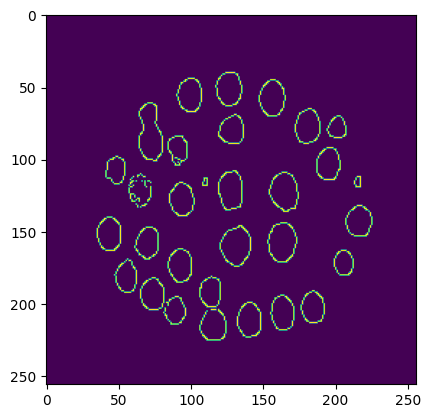

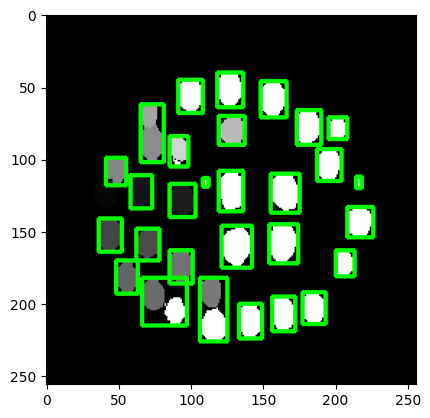

29


In [46]:
image = cv2.imread('/kaggle/input/nuclear-seg/new_dataset/final_seg_maps/L100_17.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 20, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(binary_image,100,200)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    boxes.append([x, y, w, h])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draws a green rectangle

# Save the image with bounding boxes (optional)
# cv2.imwrite('cell_masks_with_bboxes.png', image)
plt.imshow(edges)
plt.show()
plt.imshow(image)
plt.show()

print(len(boxes))

### Define a class to add gaussian noise in images

In [29]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [60]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## These cells work on colab not kaggle, for kaggle you need to run the cells given at the end of the notebook

In [61]:
# %%shell

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

In [62]:
# !rm -rf vision
# !rm -rf /content/engine.py
# !rm -rf /content/coco_eval.py
# !rm -rf /content/coco_utils.py
# !rm -rf /content/transform.py
# !rm -rf /content/utils.py


In [63]:
# %%shell

!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ec1lpowi
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ec1lpowi
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [66]:
# import transforms as T

def get_transform():
    transforms = []
    transforms.append(torchvision.transforms.PILToTensor())
    transforms.append(torchvision.transforms.ConvertImageDtype(torch.float))
    transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

In [67]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [68]:
# use our dataset and defined transformations
dataset_test = my_full_dataset
dataset = MySegmentationDataset(csv = "file_ids.csv",
#                                     augmentation =  get_transform(),
                                    transform_image = torchvision.transforms.Compose([
                                                                    torchvision.transforms.ToPILImage(),
                                                                    ToTensor(),
                                                                ]),
                                    transform_label = torchvision.transforms.Compose([

                                                                    torchvision.transforms.ToPILImage(),
                                                                    ToTensor(),

                                                                ]))

# # split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

# define training and validation data loaders
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=lambda x:tuple(zip(*x)))

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=lambda x:tuple(zip(*x)))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

## Have to convert float32 format of images to unint8 to see bounding boxes as well as images.

In [85]:
def normalize8(I):
  mn = I.min()
  mx = I.max()

  mx -= mn

  I = ((I - mn)/mx) * 255
  return I.astype(np.uint8)

In [86]:
img, target = dataset_test[2]
img = normalize8(img.numpy())
img = torch.from_numpy(img)

before 
 tensor([[[ 76,   8,   8,  ...,   8,   8,   8],
         [ 50,   8,   8,  ...,   8,   8,   8],
         [ 16,   8,   8,  ...,   8,   8,   8],
         ...,
         [  8,  47,   8,  ...,   8,   8,   8],
         [  8,  98,   8,  ...,   8,   8,   8],
         [  8, 112,   8,  ...,  10,   8,   8]],

        [[ 76,   8,   8,  ...,   8,   8,   8],
         [ 50,   8,   8,  ...,   8,   8,   8],
         [ 16,   8,   8,  ...,   8,   8,   8],
         ...,
         [  8,  47,   8,  ...,   8,   8,   8],
         [  8,  98,   8,  ...,   8,   8,   8],
         [  8, 112,   8,  ...,  10,   8,   8]],

        [[ 76,   8,   8,  ...,   8,   8,   8],
         [ 50,   8,   8,  ...,   8,   8,   8],
         [ 16,   8,   8,  ...,   8,   8,   8],
         ...,
         [  8,  47,   8,  ...,   8,   8,   8],
         [  8,  98,   8,  ...,   8,   8,   8],
         [  8, 112,   8,  ...,  10,   8,   8]]], dtype=torch.uint8)
tensor([[[ 76,   8,   8,  ...,   8,   8,   8],
         [ 50,   8,   8,  ..., 

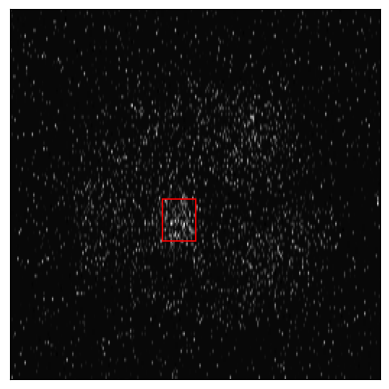

In [87]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.io import read_image

from torchvision.utils import draw_bounding_boxes

ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# img, target = dataset_test[2]
print("before \n", img)
# img = img.to(torch.uint8)
print(img)
boxes = target['boxes']
drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

# Tried two approaches to training: Method 1

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# TODO: try removing this for
for param in model.parameters():
    param.requires_grad=True
    
model.train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 291MB/s] 


In [45]:
# params=[p for p in model.parameters() if p.requires_grad]
# optimizer=torch.optim.SGD(params,lr=config.LEARNING_RATE,momentum=config.MOMENTUM,weight_decay=config.WEIGHT_DECAY)

# lr_schedule=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.005),
    ])

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 2

n_batches=len(data_loader)

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1} of {num_epochs-1}")

    time_start=time.time()
    loss_accum=0.0
    loss_mask_accum=0.0
    
    for batch_idx,(images,targets) in enumerate(data_loader,1):
        
        #Predict
        # By default newly created tensors are created on CPU, if not specified otherwise. So this applies also for your images and targets.
        # The problem here is that all operands of an operation need to be on the same device! If you leave out the to and use CPU tensors as input you will get an error message.
        images=list(image.to(device) for image in images)
        targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict=model(images,targets)     # Returns losses and detections
        loss=sum(loss for loss in loss_dict.values())
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask=loss_dict['loss_mask'].item()
        loss_accum+=loss.item()
        loss_mask_accum+=loss_mask
        
        if batch_idx% 50 ==0:
            print(f"[Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")
        
    lr_scheduler.step()
        
    
    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    
    
    elapsed = time.time() - time_start
    
    
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {config.num_epochs:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

Starting epoch 1 of 1
[Batch  50 / 528] Batch train loss:     nan. Mask-only loss:     nan
[Batch 100 / 528] Batch train loss:     nan. Mask-only loss:     nan
[Batch 150 / 528] Batch train loss:     nan. Mask-only loss:     nan
[Batch 200 / 528] Batch train loss:     nan. Mask-only loss:     nan
[Batch 250 / 528] Batch train loss:     nan. Mask-only loss:     nan


KeyboardInterrupt: 

# Method 2 

In [59]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device)

print("That's it!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [0]  [  0/132]  eta: 0:02:48  lr: 0.000043  loss: 8.2589 (8.2589)  loss_classifier: 0.6413 (0.6413)  loss_box_reg: 0.4302 (0.4302)  loss_mask: 2.4743 (2.4743)  loss_objectness: 4.1504 (4.1504)  loss_rpn_box_reg: 0.5627 (0.5627)  time: 1.2791  data: 0.2971  max mem: 7031
Epoch: [0]  [ 10/132]  eta: 0:02:02  lr: 0.000424  loss: 3.2509 (4.2137)  loss_classifier: 0.5036 (0.5085)  loss_box_reg: 0.4168 (0.4468)  loss_mask: 0.3568 (0.9148)  loss_objectness: 1.4432 (1.8862)  loss_rpn_box_reg: 0.4432 (0.4574)  time: 1.0081  data: 0.0515  max mem: 7896


KeyboardInterrupt: 

In [69]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.005),
    ])

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                     mode='min',
#                                     factor=0.2,
#                                     patience=11,
#                                     verbose=False,
#                                     threshold=0.0001,
#                                     threshold_mode='rel',
#                                     cooldown=0,
#                                     min_lr=0,
#                                     eps=1e-08)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# let's hope it trains!
from torch.optim.lr_scheduler import StepLR
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/132]  eta: 0:02:51  lr: 0.000043  loss: 9.9510 (9.9510)  loss_classifier: 0.5306 (0.5306)  loss_box_reg: 0.3711 (0.3711)  loss_mask: 5.0151 (5.0151)  loss_objectness: 3.5806 (3.5806)  loss_rpn_box_reg: 0.4536 (0.4536)  time: 1.2966  data: 0.3223  max mem: 7896
Epoch: [0]  [  1/132]  eta: 0:02:25  lr: 0.000081  loss: 8.5634 (9.2572)  loss_classifier: 0.4920 (0.5113)  loss_box_reg: 0.3348 (0.3530)  loss_mask: 4.2854 (4.6502)  loss_objectness: 3.0193 (3.2999)  loss_rpn_box_reg: 0.4318 (0.4427)  time: 1.1138  data: 0.1679  max mem: 7896
Epoch: [0]  [  2/132]  eta: 0:02:17  lr: 0.000119  loss: 8.5634 (7.8577)  loss_classifier: 0.4920 (0.4525)  loss_box_reg: 0.3600 (0.3553)  loss_mask: 4.2854 (3.7645)  loss_objectness: 3.0193 (2.7941)  loss_rpn_box_reg: 0.4536 (0.4914)  time: 1.0608  data: 0.1250  max mem: 7896
Epoch: [0]  [  3/132]  eta: 0:02:13  lr: 0.000158  loss: 5.0589 (6.4796)  loss_classifier: 0.3347 (0.4208)  loss_box_reg: 0.3600 (0.3696)  loss_mask: 1.9930 (3.0116) 

/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:272: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ar = np.asanyarray(ar)
/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


TypeError: evaluate() missing 2 required positional arguments: 'data_loader_test' and 'device'

In [ ]:
torch.save(model, './best_model.pth')

In [ ]:
# !cp -r /content/best_model.pth /content/drive/MyDrive/GSoC/nucleus_seg_model.pth

In [ ]:
!cp -r /content/drive/MyDrive/GSoC/nucleus_seg_model.pth .

In [ ]:
model = torch.load('/content/nucleus_seg_model.pth', map_location=torch.device('cpu') )
# model = torch.load('/content/nucleus_seg_model.pth')

In [48]:
# pick one image from the test set
# print(len(dataset_test)) # 50
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


In [49]:
prediction

[{'boxes': tensor([[0.0000e+00, 5.6885e-04, 3.9060e+00, 7.1013e+00],
          [1.3861e+00, 5.6885e-04, 9.0259e+00, 7.1013e+00],
          [3.9461e+00, 5.6885e-04, 1.1586e+01, 7.1013e+00],
          [6.5061e+00, 5.6885e-04, 1.4146e+01, 7.1013e+00],
          [9.0661e+00, 5.6885e-04, 1.6706e+01, 7.1013e+00],
          [1.1626e+01, 5.6885e-04, 1.9266e+01, 7.1013e+00],
          [1.4186e+01, 5.6885e-04, 2.1826e+01, 7.1013e+00],
          [1.6746e+01, 5.6885e-04, 2.4386e+01, 7.1013e+00],
          [1.9306e+01, 5.6885e-04, 2.6946e+01, 7.1013e+00],
          [2.1866e+01, 5.6885e-04, 2.9506e+01, 7.1013e+00],
          [2.4426e+01, 5.6885e-04, 3.2066e+01, 7.1013e+00],
          [2.6986e+01, 5.6885e-04, 3.4626e+01, 7.1013e+00],
          [2.9546e+01, 5.6885e-04, 3.7186e+01, 7.1013e+00],
          [3.2106e+01, 5.6885e-04, 3.9746e+01, 7.1013e+00],
          [3.4666e+01, 5.6885e-04, 4.2306e+01, 7.1013e+00],
          [3.7226e+01, 5.6885e-04, 4.4866e+01, 7.1013e+00],
          [3.9786e+01, 5.6885e-

In [ ]:
prediction[0]

{'boxes': tensor([[106.2642, 181.6425, 124.3584, 208.8731],
         [161.0977,  54.9535, 177.3862,  78.5830],
         [169.9411, 169.4467, 187.6526, 193.6272],
         [ 48.7140, 134.7793,  64.0059, 157.9431],
         [ 78.9080, 144.4491,  97.5819, 169.9808],
         [ 46.8051,  89.7780,  60.3735, 111.6368],
         [148.2699, 100.1409, 163.9590, 125.5179],
         [205.7962, 106.6663, 219.8351, 128.6519],
         [105.9534,  56.9141, 120.0474,  80.0262],
         [ 70.9090,  59.7602,  84.5598,  80.2844],
         [134.7967,  64.5665, 148.9053,  86.7765],
         [114.7043, 111.6084, 131.9527, 134.4775],
         [ 80.3938,  97.4631,  94.3239, 116.3288],
         [185.9820,  81.2964, 200.2569, 102.0303],
         [ 65.3786, 180.0051,  77.3104, 197.9244],
         [ 68.5387, 185.9255,  77.1378, 198.5746],
         [129.8776, 167.9933, 140.4644, 186.1699],
         [ 62.2272, 177.4283,  74.8751, 194.3598],
         [ 82.8883,  98.7251,  91.7362, 113.3358]]),
 'labels': tensor([1

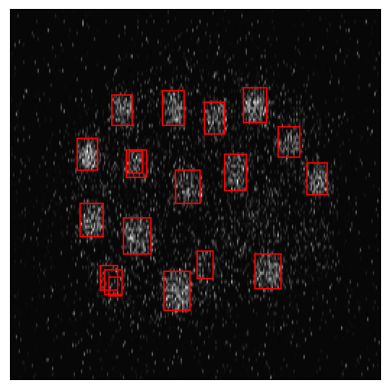

In [ ]:
# img, target = dataset_test[2]
img = normalize8(img.numpy())
img = torch.from_numpy(img)
boxes = prediction[0]['boxes']
drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

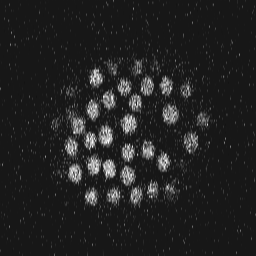

In [ ]:
a = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
a.show()

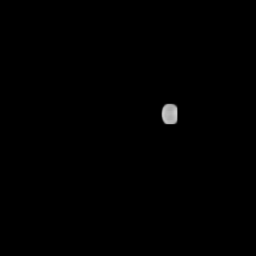

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
# image, masks = next(iter(dataset_test))
# model.eval()
# for img, i in zip(image, range(len(image))):
#     with torch.no_grad():
#       prediction = model([img.to(device)])
#     #Image.fromarray(inp.mul(255).permute(1, 2, 0).byte().numpy())
#     show_pred = Image.fromarray(prediction[i]['masks'][0, 0].mul(255).byte().cpu().numpy())
#     # show_pred[show_pred > 0.1] = 1
#     show_mask = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
#     fig, ax = plt.subplots(1,3, figsize = (10,120))

#     ax.flat[0].imshow(show_img, cmap='gray')
#     ax.flat[0].title.set_text('input image')

#     ax.flat[1].imshow(show_mask, cmap='gray')
#     ax.flat[1].title.set_text('original mask')

#     ax.flat[2].imshow(show_pred, cmap='gray')
#     ax.flat[2].title.set_text('prediction')

# Run these cells first for `evaluate` function to work. 

In [47]:
# UTILS 
import datetime
import errno
import os
import time
from collections import defaultdict, deque

import torch
import torch.distributed as dist


class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")


def collate_fn(batch):
    return tuple(zip(*batch))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print(f"| distributed init (rank {args.rank}): {args.dist_url}", flush=True)
    torch.distributed.init_process_group(
        backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [48]:
# TRANSFORM 

from typing import Dict, List, Optional, Tuple, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision import ops
from torchvision.transforms import functional as F, InterpolationMode, transforms as T


def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                _, _, width = F.get_dimensions(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target


class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        return image, target


class ToDtype(nn.Module):
    def __init__(self, dtype: torch.dtype, scale: bool = False) -> None:
        super().__init__()
        self.dtype = dtype
        self.scale = scale

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if not self.scale:
            return image.to(dtype=self.dtype), target
        image = F.convert_image_dtype(image, self.dtype)
        return image, target


class RandomIoUCrop(nn.Module):
    def __init__(
        self,
        min_scale: float = 0.3,
        max_scale: float = 1.0,
        min_aspect_ratio: float = 0.5,
        max_aspect_ratio: float = 2.0,
        sampler_options: Optional[List[float]] = None,
        trials: int = 40,
    ):
        super().__init__()
        # Configuration similar to https://github.com/weiliu89/caffe/blob/ssd/examples/ssd/ssd_coco.py#L89-L174
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.min_aspect_ratio = min_aspect_ratio
        self.max_aspect_ratio = max_aspect_ratio
        if sampler_options is None:
            sampler_options = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
        self.options = sampler_options
        self.trials = trials

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if target is None:
            raise ValueError("The targets can't be None for this transform.")

        if isinstance(image, torch.Tensor):
            if image.ndimension() not in {2, 3}:
                raise ValueError(f"image should be 2/3 dimensional. Got {image.ndimension()} dimensions.")
            elif image.ndimension() == 2:
                image = image.unsqueeze(0)

        _, orig_h, orig_w = F.get_dimensions(image)

        while True:
            # sample an option
            idx = int(torch.randint(low=0, high=len(self.options), size=(1,)))
            min_jaccard_overlap = self.options[idx]
            if min_jaccard_overlap >= 1.0:  # a value larger than 1 encodes the leave as-is option
                return image, target

            for _ in range(self.trials):
                # check the aspect ratio limitations
                r = self.min_scale + (self.max_scale - self.min_scale) * torch.rand(2)
                new_w = int(orig_w * r[0])
                new_h = int(orig_h * r[1])
                aspect_ratio = new_w / new_h
                if not (self.min_aspect_ratio <= aspect_ratio <= self.max_aspect_ratio):
                    continue

                # check for 0 area crops
                r = torch.rand(2)
                left = int((orig_w - new_w) * r[0])
                top = int((orig_h - new_h) * r[1])
                right = left + new_w
                bottom = top + new_h
                if left == right or top == bottom:
                    continue

                # check for any valid boxes with centers within the crop area
                cx = 0.5 * (target["boxes"][:, 0] + target["boxes"][:, 2])
                cy = 0.5 * (target["boxes"][:, 1] + target["boxes"][:, 3])
                is_within_crop_area = (left < cx) & (cx < right) & (top < cy) & (cy < bottom)
                if not is_within_crop_area.any():
                    continue

                # check at least 1 box with jaccard limitations
                boxes = target["boxes"][is_within_crop_area]
                ious = torchvision.ops.boxes.box_iou(
                    boxes, torch.tensor([[left, top, right, bottom]], dtype=boxes.dtype, device=boxes.device)
                )
                if ious.max() < min_jaccard_overlap:
                    continue

                # keep only valid boxes and perform cropping
                target["boxes"] = boxes
                target["labels"] = target["labels"][is_within_crop_area]
                target["boxes"][:, 0::2] -= left
                target["boxes"][:, 1::2] -= top
                target["boxes"][:, 0::2].clamp_(min=0, max=new_w)
                target["boxes"][:, 1::2].clamp_(min=0, max=new_h)
                image = F.crop(image, top, left, new_h, new_w)

                return image, target


class RandomZoomOut(nn.Module):
    def __init__(
        self, fill: Optional[List[float]] = None, side_range: Tuple[float, float] = (1.0, 4.0), p: float = 0.5
    ):
        super().__init__()
        if fill is None:
            fill = [0.0, 0.0, 0.0]
        self.fill = fill
        self.side_range = side_range
        if side_range[0] < 1.0 or side_range[0] > side_range[1]:
            raise ValueError(f"Invalid canvas side range provided {side_range}.")
        self.p = p

    @torch.jit.unused
    def _get_fill_value(self, is_pil):
        # type: (bool) -> int
        # We fake the type to make it work on JIT
        return tuple(int(x) for x in self.fill) if is_pil else 0

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if isinstance(image, torch.Tensor):
            if image.ndimension() not in {2, 3}:
                raise ValueError(f"image should be 2/3 dimensional. Got {image.ndimension()} dimensions.")
            elif image.ndimension() == 2:
                image = image.unsqueeze(0)

        if torch.rand(1) >= self.p:
            return image, target

        _, orig_h, orig_w = F.get_dimensions(image)

        r = self.side_range[0] + torch.rand(1) * (self.side_range[1] - self.side_range[0])
        canvas_width = int(orig_w * r)
        canvas_height = int(orig_h * r)

        r = torch.rand(2)
        left = int((canvas_width - orig_w) * r[0])
        top = int((canvas_height - orig_h) * r[1])
        right = canvas_width - (left + orig_w)
        bottom = canvas_height - (top + orig_h)

        if torch.jit.is_scripting():
            fill = 0
        else:
            fill = self._get_fill_value(F._is_pil_image(image))

        image = F.pad(image, [left, top, right, bottom], fill=fill)
        if isinstance(image, torch.Tensor):
            # PyTorch's pad supports only integers on fill. So we need to overwrite the colour
            v = torch.tensor(self.fill, device=image.device, dtype=image.dtype).view(-1, 1, 1)
            image[..., :top, :] = image[..., :, :left] = image[..., (top + orig_h) :, :] = image[
                ..., :, (left + orig_w) :
            ] = v

        if target is not None:
            target["boxes"][:, 0::2] += left
            target["boxes"][:, 1::2] += top

        return image, target


class RandomPhotometricDistort(nn.Module):
    def __init__(
        self,
        contrast: Tuple[float, float] = (0.5, 1.5),
        saturation: Tuple[float, float] = (0.5, 1.5),
        hue: Tuple[float, float] = (-0.05, 0.05),
        brightness: Tuple[float, float] = (0.875, 1.125),
        p: float = 0.5,
    ):
        super().__init__()
        self._brightness = T.ColorJitter(brightness=brightness)
        self._contrast = T.ColorJitter(contrast=contrast)
        self._hue = T.ColorJitter(hue=hue)
        self._saturation = T.ColorJitter(saturation=saturation)
        self.p = p

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if isinstance(image, torch.Tensor):
            if image.ndimension() not in {2, 3}:
                raise ValueError(f"image should be 2/3 dimensional. Got {image.ndimension()} dimensions.")
            elif image.ndimension() == 2:
                image = image.unsqueeze(0)

        r = torch.rand(7)

        if r[0] < self.p:
            image = self._brightness(image)

        contrast_before = r[1] < 0.5
        if contrast_before:
            if r[2] < self.p:
                image = self._contrast(image)

        if r[3] < self.p:
            image = self._saturation(image)

        if r[4] < self.p:
            image = self._hue(image)

        if not contrast_before:
            if r[5] < self.p:
                image = self._contrast(image)

        if r[6] < self.p:
            channels, _, _ = F.get_dimensions(image)
            permutation = torch.randperm(channels)

            is_pil = F._is_pil_image(image)
            if is_pil:
                image = F.pil_to_tensor(image)
                image = F.convert_image_dtype(image)
            image = image[..., permutation, :, :]
            if is_pil:
                image = F.to_pil_image(image)

        return image, target


class ScaleJitter(nn.Module):
    """Randomly resizes the image and its bounding boxes  within the specified scale range.
    The class implements the Scale Jitter augmentation as described in the paper
    `"Simple Copy-Paste is a Strong Data Augmentation Method for Instance Segmentation" <https://arxiv.org/abs/2012.07177>`_.

    Args:
        target_size (tuple of ints): The target size for the transform provided in (height, weight) format.
        scale_range (tuple of ints): scaling factor interval, e.g (a, b), then scale is randomly sampled from the
            range a <= scale <= b.
        interpolation (InterpolationMode): Desired interpolation enum defined by
            :class:`torchvision.transforms.InterpolationMode`. Default is ``InterpolationMode.BILINEAR``.
    """

    def __init__(
        self,
        target_size: Tuple[int, int],
        scale_range: Tuple[float, float] = (0.1, 2.0),
        interpolation: InterpolationMode = InterpolationMode.BILINEAR,
        antialias=True,
    ):
        super().__init__()
        self.target_size = target_size
        self.scale_range = scale_range
        self.interpolation = interpolation
        self.antialias = antialias

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if isinstance(image, torch.Tensor):
            if image.ndimension() not in {2, 3}:
                raise ValueError(f"image should be 2/3 dimensional. Got {image.ndimension()} dimensions.")
            elif image.ndimension() == 2:
                image = image.unsqueeze(0)

        _, orig_height, orig_width = F.get_dimensions(image)

        scale = self.scale_range[0] + torch.rand(1) * (self.scale_range[1] - self.scale_range[0])
        r = min(self.target_size[1] / orig_height, self.target_size[0] / orig_width) * scale
        new_width = int(orig_width * r)
        new_height = int(orig_height * r)

        image = F.resize(image, [new_height, new_width], interpolation=self.interpolation, antialias=self.antialias)

        if target is not None:
            target["boxes"][:, 0::2] *= new_width / orig_width
            target["boxes"][:, 1::2] *= new_height / orig_height
            if "masks" in target:
                target["masks"] = F.resize(
                    target["masks"],
                    [new_height, new_width],
                    interpolation=InterpolationMode.NEAREST,
                    antialias=self.antialias,
                )

        return image, target


class FixedSizeCrop(nn.Module):
    def __init__(self, size, fill=0, padding_mode="constant"):
        super().__init__()
        size = tuple(T._setup_size(size, error_msg="Please provide only two dimensions (h, w) for size."))
        self.crop_height = size[0]
        self.crop_width = size[1]
        self.fill = fill  # TODO: Fill is currently respected only on PIL. Apply tensor patch.
        self.padding_mode = padding_mode

    def _pad(self, img, target, padding):
        # Taken from the functional_tensor.py pad
        if isinstance(padding, int):
            pad_left = pad_right = pad_top = pad_bottom = padding
        elif len(padding) == 1:
            pad_left = pad_right = pad_top = pad_bottom = padding[0]
        elif len(padding) == 2:
            pad_left = pad_right = padding[0]
            pad_top = pad_bottom = padding[1]
        else:
            pad_left = padding[0]
            pad_top = padding[1]
            pad_right = padding[2]
            pad_bottom = padding[3]

        padding = [pad_left, pad_top, pad_right, pad_bottom]
        img = F.pad(img, padding, self.fill, self.padding_mode)
        if target is not None:
            target["boxes"][:, 0::2] += pad_left
            target["boxes"][:, 1::2] += pad_top
            if "masks" in target:
                target["masks"] = F.pad(target["masks"], padding, 0, "constant")

        return img, target

    def _crop(self, img, target, top, left, height, width):
        img = F.crop(img, top, left, height, width)
        if target is not None:
            boxes = target["boxes"]
            boxes[:, 0::2] -= left
            boxes[:, 1::2] -= top
            boxes[:, 0::2].clamp_(min=0, max=width)
            boxes[:, 1::2].clamp_(min=0, max=height)

            is_valid = (boxes[:, 0] < boxes[:, 2]) & (boxes[:, 1] < boxes[:, 3])

            target["boxes"] = boxes[is_valid]
            target["labels"] = target["labels"][is_valid]
            if "masks" in target:
                target["masks"] = F.crop(target["masks"][is_valid], top, left, height, width)

        return img, target

    def forward(self, img, target=None):
        _, height, width = F.get_dimensions(img)
        new_height = min(height, self.crop_height)
        new_width = min(width, self.crop_width)

        if new_height != height or new_width != width:
            offset_height = max(height - self.crop_height, 0)
            offset_width = max(width - self.crop_width, 0)

            r = torch.rand(1)
            top = int(offset_height * r)
            left = int(offset_width * r)

            img, target = self._crop(img, target, top, left, new_height, new_width)

        pad_bottom = max(self.crop_height - new_height, 0)
        pad_right = max(self.crop_width - new_width, 0)
        if pad_bottom != 0 or pad_right != 0:
            img, target = self._pad(img, target, [0, 0, pad_right, pad_bottom])

        return img, target


class RandomShortestSize(nn.Module):
    def __init__(
        self,
        min_size: Union[List[int], Tuple[int], int],
        max_size: int,
        interpolation: InterpolationMode = InterpolationMode.BILINEAR,
    ):
        super().__init__()
        self.min_size = [min_size] if isinstance(min_size, int) else list(min_size)
        self.max_size = max_size
        self.interpolation = interpolation

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        _, orig_height, orig_width = F.get_dimensions(image)

        min_size = self.min_size[torch.randint(len(self.min_size), (1,)).item()]
        r = min(min_size / min(orig_height, orig_width), self.max_size / max(orig_height, orig_width))

        new_width = int(orig_width * r)
        new_height = int(orig_height * r)

        image = F.resize(image, [new_height, new_width], interpolation=self.interpolation)

        if target is not None:
            target["boxes"][:, 0::2] *= new_width / orig_width
            target["boxes"][:, 1::2] *= new_height / orig_height
            if "masks" in target:
                target["masks"] = F.resize(
                    target["masks"], [new_height, new_width], interpolation=InterpolationMode.NEAREST
                )

        return image, target


def _copy_paste(
    image: torch.Tensor,
    target: Dict[str, Tensor],
    paste_image: torch.Tensor,
    paste_target: Dict[str, Tensor],
    blending: bool = True,
    resize_interpolation: F.InterpolationMode = F.InterpolationMode.BILINEAR,
) -> Tuple[torch.Tensor, Dict[str, Tensor]]:

    # Random paste targets selection:
    num_masks = len(paste_target["masks"])

    if num_masks < 1:
        # Such degerante case with num_masks=0 can happen with LSJ
        # Let's just return (image, target)
        return image, target

    # We have to please torch script by explicitly specifying dtype as torch.long
    random_selection = torch.randint(0, num_masks, (num_masks,), device=paste_image.device)
    random_selection = torch.unique(random_selection).to(torch.long)

    paste_masks = paste_target["masks"][random_selection]
    paste_boxes = paste_target["boxes"][random_selection]
    paste_labels = paste_target["labels"][random_selection]

    masks = target["masks"]

    # We resize source and paste data if they have different sizes
    # This is something we introduced here as originally the algorithm works
    # on equal-sized data (for example, coming from LSJ data augmentations)
    size1 = image.shape[-2:]
    size2 = paste_image.shape[-2:]
    if size1 != size2:
        paste_image = F.resize(paste_image, size1, interpolation=resize_interpolation)
        paste_masks = F.resize(paste_masks, size1, interpolation=F.InterpolationMode.NEAREST)
        # resize bboxes:
        ratios = torch.tensor((size1[1] / size2[1], size1[0] / size2[0]), device=paste_boxes.device)
        paste_boxes = paste_boxes.view(-1, 2, 2).mul(ratios).view(paste_boxes.shape)

    paste_alpha_mask = paste_masks.sum(dim=0) > 0

    if blending:
        paste_alpha_mask = F.gaussian_blur(
            paste_alpha_mask.unsqueeze(0),
            kernel_size=(5, 5),
            sigma=[
                2.0,
            ],
        )

    # Copy-paste images:
    image = (image * (~paste_alpha_mask)) + (paste_image * paste_alpha_mask)

    # Copy-paste masks:
    masks = masks * (~paste_alpha_mask)
    non_all_zero_masks = masks.sum((-1, -2)) > 0
    masks = masks[non_all_zero_masks]

    # Do a shallow copy of the target dict
    out_target = {k: v for k, v in target.items()}

    out_target["masks"] = torch.cat([masks, paste_masks])

    # Copy-paste boxes and labels
    boxes = ops.masks_to_boxes(masks)
    out_target["boxes"] = torch.cat([boxes, paste_boxes])

    labels = target["labels"][non_all_zero_masks]
    out_target["labels"] = torch.cat([labels, paste_labels])

    # Update additional optional keys: area and iscrowd if exist
    if "area" in target:
        out_target["area"] = out_target["masks"].sum((-1, -2)).to(torch.float32)

    if "iscrowd" in target and "iscrowd" in paste_target:
        # target['iscrowd'] size can be differ from mask size (non_all_zero_masks)
        # For example, if previous transforms geometrically modifies masks/boxes/labels but
        # does not update "iscrowd"
        if len(target["iscrowd"]) == len(non_all_zero_masks):
            iscrowd = target["iscrowd"][non_all_zero_masks]
            paste_iscrowd = paste_target["iscrowd"][random_selection]
            out_target["iscrowd"] = torch.cat([iscrowd, paste_iscrowd])

    # Check for degenerated boxes and remove them
    boxes = out_target["boxes"]
    degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
    if degenerate_boxes.any():
        valid_targets = ~degenerate_boxes.any(dim=1)

        out_target["boxes"] = boxes[valid_targets]
        out_target["masks"] = out_target["masks"][valid_targets]
        out_target["labels"] = out_target["labels"][valid_targets]

        if "area" in out_target:
            out_target["area"] = out_target["area"][valid_targets]
        if "iscrowd" in out_target and len(out_target["iscrowd"]) == len(valid_targets):
            out_target["iscrowd"] = out_target["iscrowd"][valid_targets]

    return image, out_target


class SimpleCopyPaste(torch.nn.Module):
    def __init__(self, blending=True, resize_interpolation=F.InterpolationMode.BILINEAR):
        super().__init__()
        self.resize_interpolation = resize_interpolation
        self.blending = blending

    def forward(
        self, images: List[torch.Tensor], targets: List[Dict[str, Tensor]]
    ) -> Tuple[List[torch.Tensor], List[Dict[str, Tensor]]]:
        torch._assert(
            isinstance(images, (list, tuple)) and all([isinstance(v, torch.Tensor) for v in images]),
            "images should be a list of tensors",
        )
        torch._assert(
            isinstance(targets, (list, tuple)) and len(images) == len(targets),
            "targets should be a list of the same size as images",
        )
        for target in targets:
            # Can not check for instance type dict with inside torch.jit.script
            # torch._assert(isinstance(target, dict), "targets item should be a dict")
            for k in ["masks", "boxes", "labels"]:
                torch._assert(k in target, f"Key {k} should be present in targets")
                torch._assert(isinstance(target[k], torch.Tensor), f"Value for the key {k} should be a tensor")

        # images = [t1, t2, ..., tN]
        # Let's define paste_images as shifted list of input images
        # paste_images = [t2, t3, ..., tN, t1]
        # FYI: in TF they mix data on the dataset level
        images_rolled = images[-1:] + images[:-1]
        targets_rolled = targets[-1:] + targets[:-1]

        output_images: List[torch.Tensor] = []
        output_targets: List[Dict[str, Tensor]] = []

        for image, target, paste_image, paste_target in zip(images, targets, images_rolled, targets_rolled):
            output_image, output_data = _copy_paste(
                image,
                target,
                paste_image,
                paste_target,
                blending=self.blending,
                resize_interpolation=self.resize_interpolation,
            )
            output_images.append(output_image)
            output_targets.append(output_data)

        return output_images, output_targets

    def __repr__(self) -> str:
        s = f"{self.__class__.__name__}(blending={self.blending}, resize_interpolation={self.resize_interpolation})"
        return s

In [49]:
# COCO UTILS 
import os

import torch
import torch.utils.data
import torchvision
# import transforms as T
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask:
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]

        anno = target["annotations"]

        anno = [obj for obj in anno if obj["iscrowd"] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different criteria for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {"images": [], "categories": [], "annotations": []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"]
        img_dict = {}
        img_dict["id"] = image_id
        img_dict["height"] = img.shape[-2]
        img_dict["width"] = img.shape[-1]
        dataset["images"].append(img_dict)
        bboxes = targets["boxes"].clone()
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets["labels"].tolist()
        areas = targets["area"].tolist()
        iscrowd = targets["iscrowd"].tolist()
        if "masks" in targets:
            masks = targets["masks"]
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if "keypoints" in targets:
            keypoints = targets["keypoints"]
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann["image_id"] = image_id
            ann["bbox"] = bboxes[i]
            ann["category_id"] = labels[i]
            categories.add(labels[i])
            ann["area"] = areas[i]
            ann["iscrowd"] = iscrowd[i]
            ann["id"] = ann_id
            if "masks" in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if "keypoints" in targets:
                ann["keypoints"] = keypoints[i]
                ann["num_keypoints"] = sum(k != 0 for k in keypoints[i][2::3])
            dataset["annotations"].append(ann)
            ann_id += 1
    dataset["categories"] = [{"id": i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    # FIXME: This is... awful?
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode="instances", use_v2=False, with_masks=False):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    if use_v2:
        from torchvision.datasets import wrap_dataset_for_transforms_v2

        dataset = torchvision.datasets.CocoDetection(img_folder, ann_file, transforms=transforms)
        target_keys = ["boxes", "labels", "image_id"]
        if with_masks:
            target_keys += ["masks"]
        dataset = wrap_dataset_for_transforms_v2(dataset, target_keys=target_keys)
    else:
        # TODO: handle with_masks for V1?
        t = [ConvertCocoPolysToMask()]
        if transforms is not None:
            t.append(transforms)
        transforms = T.Compose(t)

        dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset

In [50]:
# COCO EVAL 
import copy
import io
from contextlib import redirect_stdout

import numpy as np
import pycocotools.mask as mask_util
import torch
# import utils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


class CocoEvaluator:
    def __init__(self, coco_gt, iou_types):
        if not isinstance(iou_types, (list, tuple)):
            raise TypeError(f"This constructor expects iou_types of type list or tuple, instead  got {type(iou_types)}")
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print(f"IoU metric: {iou_type}")
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        if iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        if iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        raise ValueError(f"Unknown iou type {iou_type}")

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "keypoints": keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = utils.all_gather(img_ids)
    all_eval_imgs = utils.all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


def evaluate(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))

In [54]:
# ENGINE 

import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
# import utils
# from coco_eval import CocoEvaluator
# from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader_test, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
#         res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator